In [1]:
import drawSvg as draw
import yt
import numpy as np
import ipywidgets
import matplotlib as mpl
from dataclasses import dataclass

In [2]:
class Style(draw.elements._TextContainingElement):
    TAG_NAME = 'style'

In [3]:
ds = yt.testing.fake_amr_ds(geometry = "cylindrical")

yt : [INFO     ] 2020-10-08 13:47:19,710 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-10-08 13:47:19,712 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-10-08 13:47:19,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-10-08 13:47:19,715 Parameters: domain_right_edge         = [1.         1.         6.28318531]
yt : [INFO     ] 2020-10-08 13:47:19,716 Parameters: cosmological_simulation   = 0.0


In [4]:
final_level = 3
grids = []
g = ds.index.select_grids(final_level)[3]
while g is not None:
    grids.append(g)
    g = g.Parent
grids.sort(key = lambda a: a.Level)

yt : [WARNING  ] 2020-10-08 13:47:19,828 In cylindrical geometry, gradient fields may contain artifacts near cartesian axes.


In [5]:
@dataclass
class SpaceScales:
    px0: float
    px1: float
    py0: float
    py1: float
    x0: float
    x1: float
    y0: float
    y1: float
    
    def x_sc(self, v):
    # margin is assumed to have been taken into account already
        return ((v - self.x0)/(self.x1 - self.x0)) * (self.px1 - self.px0) + self.px0
    
    def y_sc(self, v):
        return ((v - self.y0)/(self.y1 - self.y0)) * (self.py1 - self.py0) + self.py0
    
    def draw_wedge(self, r0, theta0, r1, theta1, fill = "none"):
        p = draw.Path(fill = fill, stroke = "black")
        p.arc(self.x_sc(0), self.y_sc(0), self.x_sc(r0) - self.x_sc(0), theta0, theta1, cw = False)
        p.arc(self.x_sc(0), self.y_sc(0), self.x_sc(r1) - self.x_sc(0), theta1, theta0, cw = True, includeL = True)
        p.Z()
        return p
    
    def draw_cell(self, x0, y0, x1, y1, fill = "none"):
        p = draw.Rectangle(self.x_sc(x0), self.y_sc(y0),
                           self.x_sc(x1) - self.x_sc(x0),
                           self.y_sc(y1) - self.y_sc(y0),
                           fill = fill, stroke = "black")
        return p

In [6]:
grids = [
    [0, 1, 4, -90, 90, 12],
    [0.25, 0.75, 4, 15, 90, 8]
]
n_total = sum(_[2] * _[5] for _ in grids)

n_row = 9
n_col = n_total // n_row

norm = mpl.colors.Normalize(vmin = 0, vmax=n_total - 1)
cmap = mpl.cm.Spectral

In [7]:
print(n_total)

80


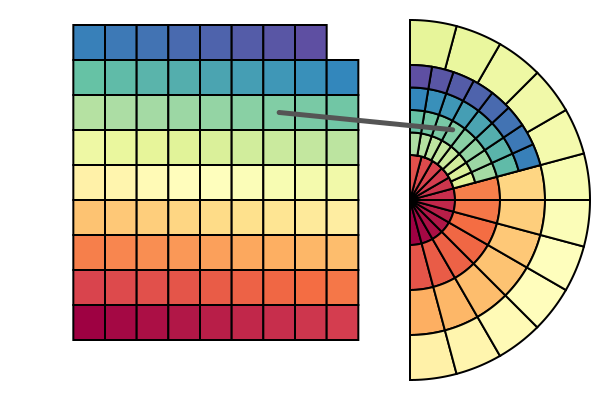

In [8]:
margin = 10
width, height = 600, 400
ibbox = [0, 400, 0, 400]
cbbox = [400, 600, 0, 400]

coord_space = SpaceScales(cbbox[0] + margin, cbbox[1] - margin, cbbox[2] - margin, cbbox[3] + margin, 0, 1, -1.1, 1.1)
index_space = SpaceScales(ibbox[0] + margin, ibbox[1] - margin, ibbox[2] - margin, ibbox[3] + margin, 0, 12, 0, 12)

canvas = draw.Drawing(width = width, height = height, id = "index_coord_figure")
coord_group = draw.Group(id = "coordinate_space_cells")
canvas.append(coord_group)

index_group = draw.Group(id = "index_space_cells")
canvas.append(index_group)

lines_group = draw.Group(id = "coord_index_lines")
canvas.append(lines_group)

cell_side = 1

n = 0
for r0, r1, nr, theta0, theta1, ntheta in grids:
    dr = (r1 - r0)/nr
    dtheta = (theta1 - theta0)/ntheta
    for i in range(nr):
        rc0 = r0 + dr * i
        rc1 = r0 + dr * (i + 1)
        for j in range(ntheta):
            thetac0 = theta0 + dtheta * j
            thetac1 = theta0 + dtheta * (j + 1)
            fill = mpl.colors.to_hex(cmap(norm(n)))
            args = {'class': 'cell', 'data-cell-i': f"{i: 3d}", 'data-cell-j': f"{j: 3d}", 'data-cell': f"{n: 3d}",
                    'data-theta-0': f"{thetac0: 3.2f}", 'data-theta-1': f"{thetac1: 3.2f}", 'data-r-0': f"{rc0: 0.3f}", "data-r-1": f"{rc1: 0.3f}"}
            if n == 60:
                args['class'] += " highlighted"
            g = draw.Group(id = f"coord_cell_{n:02d}")
            g.appendTitle(f"cell: {i: 2d} {j: 2d}")
            p = coord_space.draw_wedge(rc0, thetac0, rc1, thetac1,
                           fill = fill)
            p.args.update(args)
            g.append(p)
            coord_group.append(g)
            
            g = draw.Group(id = f"index_cell_{n:02d}")
            g.appendTitle(f"cell: {i: 2d} {j: 2d}")
            col = n % n_row + 2
            row = n // n_row + 2
            p = index_space.draw_cell(col * cell_side,
                                      row * cell_side,
                                      (col + 1) * cell_side,
                                      (row + 1) * cell_side,
                           fill = fill)
            p.args.update(args)
            g.append(p)
            index_group.append(g)
            
            t = (np.pi / 180) * ((thetac0 + thetac1)/2.0)
            x0 = coord_space.x_sc((np.cos(t) * (rc0 + rc1)/2))
            y0 = coord_space.y_sc((np.sin(t) * (rc0 + rc1)/2))
            x1 = index_space.x_sc((col + 0.5) * cell_side)
            y1 = index_space.y_sc((row + 0.5) * cell_side)
            l = draw.Line(x0, y0, x1, y1)
            l.args.update(args)
            l.args["class"] += " cell-line"
                
            lines_group.append(l)
            n += 1

# Now, let's draw the grids in index space

style = """
.cell {
  stroke-width: 2;
}

.cell-line {
  visibility: hidden;
}

.cell-line.highlighted {
  visibility: visible;
  stroke: #555555;
  stroke-width: 5;
  stroke-linecap: round;
}
"""

canvas.append(Style(style))

display(canvas)
canvas.saveSvg("../content/images/indexing/coordinate_space.svg")